## imports

In [7]:
import os
import pprint
import tempfile
import urllib

import absl
import tensorflow as tf
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

from tfx import v1 as tfx

from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.types import Channel
from tfx.components import CsvExampleGen
from tfx.proto import example_gen_pb2

from google.protobuf.json_format import MessageToDict

print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.13.1
TFX version: 1.14.0


In [21]:
# Location of the pipeline metadata store
_pipeline_root = './tfx/'

In [22]:
# Initialize the InteractiveContext
context = InteractiveContext(pipeline_root=_pipeline_root)

In [23]:
# defining the output configurations

output = example_gen_pb2.Output(
split_config=example_gen_pb2.SplitConfig(splits=[
example_gen_pb2.SplitConfig.Split(name='train', hash_buckets=6),
example_gen_pb2.SplitConfig.Split(name='eval', hash_buckets=2),
example_gen_pb2.SplitConfig.Split(name='test', hash_buckets=2)]))
print(output)


split_config {
  splits {
    name: "train"
    hash_buckets: 6
  }
  splits {
    name: "eval"
    hash_buckets: 2
  }
  splits {
    name: "test"
    hash_buckets: 2
  }
}



In [24]:
# Ingest the data through ExampleGen
example_gen = tfx.components.ImportExampleGen(input_base="E:/Projects/ImageClassification/tfrecordImagesData",output_config=output)

# Run the component
context.run(example_gen)

ExecutionResult(
    component_id: ImportExampleGen
    execution_id: 1
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=ImportExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [25]:
# Print split names and URI
artifact = example_gen.outputs['examples'].get()[0]
print(artifact.split_names, artifact.uri)

["train", "eval", "test"] ./tfx/ImportExampleGen\examples\1


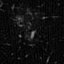

'Class ID: 0'


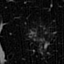

'Class ID: 0'


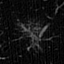

'Class ID: 0'


In [26]:
import IPython.display as display

# Get the URI of the output artifact representing the training examples, which is a directory
train_uri = os.path.join(example_gen.outputs['examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Description per example
# image_feature_description = {
#     'label': tf.io.FixedLenFeature([], tf.int64),
#     'image_raw': tf.io.FixedLenFeature([], tf.string),
# }
image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }


# Image parser function
def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

# Map the parser to the dataset
parsed_image_dataset = dataset.map(_parse_image_function)

# Display the first three images
for features in parsed_image_dataset.take(3):
    image_raw = features['image'].numpy()
    display.display(display.Image(data=image_raw))
    pprint.pprint('Class ID: {}'.format(features['label'].numpy()))

### StatisticsGen


In [27]:
# Run StatisticsGen
statistics_gen = tfx.components.StatisticsGen(
    examples=example_gen.outputs['examples'])

context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [28]:
context.show(statistics_gen.outputs['statistics'])

### SchemaGen

In [29]:
# Run SchemaGen
schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)
context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [30]:
# Visualize the results
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'image',BYTES,required,,-
'label',INT,required,,-


### ExampleValidator

In [31]:
# Run ExampleValidator
example_validator = tfx.components.ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])
context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [32]:
# Visualize the results. There should be no anomalies.
context.show(example_validator.outputs['anomalies'])

In [33]:
_transform_module_file = 'components/Lungs_transform.py'

In [34]:
%%writefile {_transform_module_file}


import tensorflow as tf
import tensorflow_transform as tft

# Keys
_LABEL_KEY = 'label'
_IMAGE_KEY = 'image'

def _transformed_name(key):
    return key + '_xf'

def _image_parser(image_str):
    '''Converts the images to a float tensor, resizes, and scales them.'''
    image = tf.image.decode_jpeg(image_str, channels=3)
    image = tf.image.resize(image, [64, 64])  # Resize images to 224x224
    image = tf.cast(image, tf.float32)
    return image

def _label_parser(label_id):
    '''Converts labels to one-hot encoding.'''
    # Assuming you have two classes: benign (0) and malignant (1)
    
    return label_id

def preprocessing_fn(inputs):
    """tf.transform's callback function for preprocessing inputs.
    Args:
        inputs: map from feature keys to raw not-yet-transformed features.
    Returns:
        Map from string feature key to transformed feature operations.
    """
    
    # Convert the raw image and labels to a float array and
    # one-hot encoded labels, respectively.
    outputs = {
        _transformed_name(_IMAGE_KEY):
            tf.map_fn(
                _image_parser,
                tf.squeeze(inputs[_IMAGE_KEY], axis=1),
                dtype=tf.float32),
        _transformed_name(_LABEL_KEY):
            tf.map_fn(
                _label_parser,
                tf.squeeze(inputs[_LABEL_KEY], axis=1),
                dtype=tf.int64)
    }
    
    # Scale the pixel values from 0 to 1
    outputs[_transformed_name(_IMAGE_KEY)] = outputs[_transformed_name(_IMAGE_KEY)] / 255.0
    
    return outputs


Overwriting components/Lungs_transform.py


In [35]:
# Ignore TF warning messages
tf.get_logger().setLevel('ERROR')

# Setup the Transform component
transform = tfx.components.Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_transform_module_file))

# Run the component
context.run(transform)

ExecutionResult(
    component_id: Transform
    execution_id: 5
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [36]:
# Get the URI of the output artifact representing the transformed examples, which is a directory
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'Split-train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

In [37]:
# Define a helper function to get individual examples
def get_records(dataset, num_records):
    '''Extracts records from the given dataset.
    Args:
        dataset (TFRecordDataset): dataset saved by ExampleGen
        num_records (int): number of records to preview
    '''
    
    # initialize an empty list
    records = []
    
    # Use the `take()` method to specify how many records to get
    for tfrecord in dataset.take(num_records):
        
        # Get the numpy property of the tensor
        serialized_example = tfrecord.numpy()
        
        # Initialize a `tf.train.Example()` to read the serialized data
        example = tf.train.Example()
        
        # Read the example data (output is a protocol buffer message)
        example.ParseFromString(serialized_example)
        
        # convert the protocol bufffer message to a Python dictionary
        example_dict = (MessageToDict(example))
        
        # append to the records list
        records.append(example_dict)
        
    return records

In [38]:
# Get 1 record from the dataset
sample_records = get_records(dataset, 1)

# Print the output
pp.pprint(sample_records)

[{'features': {'feature': {'image_xf': {'floatList': {'value': [0.11764707,
                                                                0.11764707,
                                                                0.11764707,
                                                                0.07450981,
                                                                0.07450981,
                                                                0.07450981,
                                                                0.03137255,
                                                                0.03137255,
                                                                0.03137255,
                                                                0.039215688,
                                                                0.039215688,
                                                                0.039215688,
                                                                0.058823533,
        

### Training Component

In [39]:
_trainer_module_file = "components/trainer.py"

In [40]:
%%writefile {_trainer_module_file}
import os
import tensorflow as tf
import tensorflow_transform as tft
from tensorflow.keras import layers, models
from tfx.components.trainer.fn_args_utils import FnArgs
from tensorflow import keras
from kerastuner.engine import base_tuner
from typing import NamedTuple, Dict, Text, Any
from pathlib import Path

# Constants
_IMAGE_KEY = 'image_xf'
_LABEL_KEY = 'label_xf'

# Defining a structure(NamedTuple) that can hold both the tuner tool (base_tuner) and the training instructions(fit_kwargs) together
TunerFnResult = NamedTuple('TunerFnResult', [('tuner', base_tuner.BaseTuner),
                                             ('fit_kwargs', Dict[Text, Any])])

# 1. Load compressed dataset
def _gzip_reader_fn(filenames):  
    '''Load compressed dataset
    Args:
        filenames: filenames of TFRecords to load
    Returns:
        TFRecordDataset loaded from the filenames
    '''
    return tf.data.TFRecordDataset(filenames, compression_type='GZIP')

def _input_fn(file_pattern, tf_transform_output, num_epochs, batch_size=32) -> tf.data.Dataset:
    '''Create batches of features and labels from TF Records
    Args:
        file_pattern: List of files or patterns of file paths containing Example records.
        tf_transform_output: The transform output graph from TensorFlow Transform (TF Transform) that contains information about how features have been transformed or preprocessed.
        num_epochs: Integer specifying the number of times to read through the dataset. 
                    If None, cycles through the dataset forever.
        batch_size: An int representing the number of records to combine in a single batch.
    Returns:
        A dataset of dict elements, (or a tuple of dict elements and label). 
        Each dict maps feature keys to Tensor or SparseTensor objects.
    '''
    transformed_feature_spec = tf_transform_output.transformed_feature_spec().copy()
    dataset = tf.data.experimental.make_batched_features_dataset(
        file_pattern=file_pattern,
        batch_size=batch_size,
        features=transformed_feature_spec,
        reader=_gzip_reader_fn,
        num_epochs=num_epochs,
        label_key=_LABEL_KEY
    )
    return dataset

# 3. Applying the preprocessing graph to model inputs
def _get_serve_tf_examples_fn(model, tf_transform_output):
    """Returns a function that parses a serialized tf.Example."""
    model.tft_layer = tf_transform_output.transform_features_layer()

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None], dtype=tf.string, name='examples')
    ])
    def serve_tf_examples_fn(serialized_tf_examples):
        """Returns the output to be used in the serving signature."""
        feature_spec = tf_transform_output.raw_feature_spec()
        
        feature_spec.pop("label")
        parsed_features = tf.io.parse_example(
            serialized_tf_examples, feature_spec
        )

        transformed_features = model.tft_layer(parsed_features)
        outputs = model(transformed_features)
        return {"outputs": outputs}

    return serve_tf_examples_fn

def _get_transform_features_signature(model, tf_transform_output):
    """Returns a serving signature that applies tf.Transform to features."""
    model.tft_layer_eval = tf_transform_output.transform_features_layer()

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None], dtype=tf.string, name='examples')
    ])
    def transform_features_fn(serialized_tf_example):
        """Returns the transformed_features to be fed as input to evaluator."""
        feature_spec = tf_transform_output.raw_feature_spec()
        parsed_features = tf.io.parse_example(serialized_tf_example, feature_spec)
        transformed_features = model.tft_layer_eval(parsed_features)
        return transformed_features

    return transform_features_fn

def export_serving_model(tf_transform_output, model, output_dir):
    """Exports a keras model for serving.
    Args:
        tf_transform_output: Wrapper around output of tf.Transform.
        model: A keras model to export for serving.
        output_dir: A directory where the model will be exported to.
    """
    model.tft_layer = tf_transform_output.transform_features_layer()

    signatures = {
        'serving_default': _get_serve_tf_examples_fn(model, tf_transform_output),
        'transform_features': _get_transform_features_signature(model, tf_transform_output),
    }

    model.save(output_dir, save_format='tf', signatures=signatures)

import tensorflow as tf
from kerastuner import HyperParameters

import tensorflow as tf

def build_model():
    """Builds a Keras CNN model for image classification without hyperparameter tuning.

    Returns:
        A compiled Keras model.
    """
    input_layer = tf.keras.Input(shape=(64,64, 3), name=_IMAGE_KEY)

    base_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=input_layer
    )
    base_model.trainable = False  # Freeze the base model layers

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # For binary classification, use 1 unit with sigmoid activation
    output_layer = layers.Dense(1, activation='sigmoid', name='output')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)




    # Convolutional layers with fixed parameters
    # x = tf.keras.layers.Conv2D(
    #     filters=64,  # Number of filters
    #     kernel_size=3,  # Size of the kernel
    #     activation='relu'
    # )(input_layer)
    # # x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # # x = tf.keras.layers.Conv2D(
    # #     filters=128,  # Number of filters
    # #     kernel_size=3,  # Size of the kernel
    # #     activation='relu'
    # # )(x)
    # # x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # # x = tf.keras.layers.Conv2D(
    # #     filters=256,  # Number of filters
    # #     kernel_size=3,  # Size of the kernel
    # #     activation='relu'
    # # )(x)
    # x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    # # Flatten and dense layers
    # x = tf.keras.layers.Flatten()(x)
    # x = tf.keras.layers.Dense(
    #     units=128,  # Number of units in the dense layer
    #     activation='relu'
    # )(x)
    # x = tf.keras.layers.Dropout(0.3)(x)  # Dropout rate






    # # Output layer
    # output_layer = tf.keras.layers.Dense(2, activation='softmax')(x)  # Binary classification

    # # Create the model
    # model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1),  # Fixed learning rate
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary for debugging purposes (optional)
    model.summary()

    return model

def run_fn(fn_args: FnArgs) -> None:
    """Defines and trains the model.
    Args:
        fn_args: Holds args as name/value pairs. fn_args: This is an object of type FnArgs that holds arguments as name/value pairs. 
    """
    tf_transform_output = tft.TFTransformOutput(fn_args.transform_graph_path)
    print(tf_transform_output.transformed_feature_spec())
    train_set = _input_fn(fn_args.train_files, tf_transform_output, 10)
    # for features in train_set.take(1):
    #     print(features.keys())

    val_set = _input_fn(fn_args.eval_files, tf_transform_output, 10)

    # Build the model
    model = build_model()

    # Callbacks
    log_dir = os.path.join(os.path.dirname(fn_args.serving_model_dir), 'logs')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir, update_freq='batch'
    )
    
    # Train the model
    model.fit(x=train_set, validation_data=val_set, callbacks=[tensorboard_callback])

    # Save the model
    export_serving_model(tf_transform_output, model, fn_args.serving_model_dir)


Overwriting components/trainer.py


In [41]:
from tfx.proto import example_gen_pb2, trainer_pb2
trainer = tfx.components.Trainer(
    module_file=_trainer_module_file,
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    train_args=trainer_pb2.TrainArgs(splits=['train']),
    eval_args=trainer_pb2.EvalArgs(splits=['eval']))


In [42]:
context.run(trainer, enable_cache=False)

{'image_xf': FixedLenFeature(shape=[64, 64, 3], dtype=tf.float32, default_value=None), 'label_xf': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None)}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_xf (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['image_xf[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (N

ExecutionResult(
    component_id: Trainer
    execution_id: 6
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        model_run: OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

### Load TensorBoard


In [43]:
# Get artifact uri of trainer model output
model_artifact_dir = trainer.outputs['model'].get()[0].uri

# List subdirectories artifact uri
print(f'contents of model artifact directory:{os.listdir(model_artifact_dir)}')

# Define the model directory
model_dir = os.path.join(model_artifact_dir, 'Format-Serving')

# List contents of model directory
print(f'contents of model directory: {os.listdir(model_dir)}')


contents of model artifact directory:['Format-Serving', 'logs']
contents of model directory: ['assets', 'fingerprint.pb', 'keras_metadata.pb', 'saved_model.pb', 'variables']


In [28]:
# log_dir = os.path.join(model_artifact_dir, 'logs/')

# %load_ext tensorboard
# %tensorboard --logdir {log_dir} 


### TFMA (Tensorflow model Analysis)


In [44]:
import tensorflow_model_analysis as tfma
import tensorflow as tf

import sys
import os

# stop tf warnings 
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


In [50]:
# may need to run this every time
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension install --py --symlink tensorflow_model_analysis --sys-prefix
!jupyter nbextension enable --py tensorflow_model_analysis --sys-prefix


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok
Installing d:\Users\ASUS\anaconda3\envs\environment_tfx\lib\site-packages\tensorflow_model_analysis\static -> tensorflow_model_analysis
- Validating: ok

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable tensorflow_model_analysis --py --sys-prefix
    
Enabling notebook extension tensorflow_model_analysis/extension...
      - Validating: ok


In [45]:
eval_dir = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'Split-eval')
eval_dir_full = os.path.join(eval_dir,"transformed_examples-00000-of-00001.gz")
eval_dir_full


'./tfx/Transform\\transformed_examples\\5\\Split-eval\\transformed_examples-00000-of-00001.gz'

In [46]:
dataset = tf.data.TFRecordDataset(eval_dir_full, compression_type="GZIP")
from google.protobuf.json_format import MessageToDict

# Define a helper function to get individual examples
def get_records(dataset, num_records):
    '''Extracts records from the given dataset.
    Args:
        dataset (TFRecordDataset): dataset saved by ExampleGen
        num_records (int): number of records to preview
    '''
    
    # initialize an empty list
    records = []
    
    # Use the `take()` method to specify how many records to get
    for tfrecord in dataset.take(num_records):
        
        # Get the numpy property of the tensor
        serialized_example = tfrecord.numpy()
        
        # Initialize a `tf.train.Example()` to read the serialized data
        example = tf.train.Example()
        
        # Read the example data (output is a protocol buffer message)
        example.ParseFromString(serialized_example)
        
        # convert the protocol bufffer message to a Python dictionary
        example_dict = (MessageToDict(example))
        
        # append to the records list
        records.append(example_dict)
        
    return records



# Get 3 records from the dataset
from pprint import pprint 

sample_records = get_records(dataset,1)

# Print the output
pprint(sample_records)


[{'features': {'feature': {'image_xf': {'floatList': {'value': [0.09019608,
                                                                0.09019608,
                                                                0.09019608,
                                                                0.14901961,
                                                                0.14901961,
                                                                0.14901961,
                                                                0.09019608,
                                                                0.09019608,
                                                                0.09019608,
                                                                0.050980397,
                                                                0.050980397,
                                                                0.050980397,
                                                                0.043137256,
        

In [65]:
_EVAL_DATA_FILE =eval_dir_full # path to evaluation data
_MODEL_DIR = model_dir


In [66]:
print(_EVAL_DATA_FILE)
print(_MODEL_DIR)


./tfx/Transform\transformed_examples\5\Split-eval\transformed_examples-00000-of-00001.gz
./tfx/Trainer\model\6\Format-Serving


In [67]:
eval_shared_model = tfma.default_eval_shared_model(
    eval_saved_model_path=_MODEL_DIR, tags=[tf.saved_model.SERVING])


In [68]:
eval_shared_model

EvalSharedModel(model_path='./tfx/Trainer\\model\\6\\Format-Serving', add_metrics_callbacks=[], include_default_metrics=True, example_weight_key=None, additional_fetches=None, model_loader=<tensorflow_model_analysis.api.types.ModelLoader object at 0x000002060C073980>, model_name='', model_type='tf_estimator', rubber_stamp=False, is_baseline=False, resource_hints=None, backend_config=None)

In [69]:
##  tfma.EvalConfig object must be defined that provides specifications for the model, metrics, and slices that are to be evaluated
eval_config=tfma.EvalConfig(
        model_specs=[tfma.ModelSpec(signature_name='serving_default',
                                    label_key='label_xf' , 
                                    preprocessing_function_names=['transform_features'])], # model specs
        slicing_specs=[tfma.SlicingSpec()], # slicing_specs is a list of tfma.SlicingSpec objects. Each SlicingSpec specifies a way to slice the data.
        metrics_specs=[
              tfma.MetricsSpec(metrics=[
                tfma.MetricConfig(class_name='BinaryAccuracy'),
                tfma.MetricConfig(class_name='Precision'),
                tfma.MetricConfig(class_name='ExampleCount'),
                tfma.MetricConfig(class_name='Recall'),
                tfma.MetricConfig(class_name='AUC'),
                tfma.MetricConfig(class_name='F1Score')
              ])])



print(eval_config)


# All the metrics (based on the type of model) can be
# displayed in TFMA by providing them in the metrics_specs argument to the
# EvalConfig:


model_specs {
  signature_name: "serving_default"
  label_key: "label_xf"
  preprocessing_function_names: "transform_features"
}
slicing_specs {
}
metrics_specs {
  metrics {
    class_name: "BinaryAccuracy"
  }
  metrics {
    class_name: "Precision"
  }
  metrics {
    class_name: "ExampleCount"
  }
  metrics {
    class_name: "Recall"
  }
  metrics {
    class_name: "AUC"
  }
  metrics {
    class_name: "F1Score"
  }
}



In [71]:
# eval_result = tfma.run_model_analysis(
#     eval_shared_model=eval_shared_model,
#     eval_config=eval_config,
#     data_location=_EVAL_DATA_FILE,
#     output_path="./eval_result_DO_0.1_another",
#     file_format='tfrecords',
    
# )

In [56]:
# tfma.view.render_slicing_metrics(eval_result)


### Model Analysis for Fairness


In [83]:
##  tfma.EvalConfig object must be defined that provides specifications for the model, metrics, and slices that are to be evaluated
eval_config=tfma.EvalConfig(
        model_specs=[tfma.ModelSpec(label_key='label_xf')], # model specs
        slicing_specs=[tfma.SlicingSpec()], # slicing_specs is a list of tfma.SlicingSpec objects. Each SlicingSpec specifies a way to slice the data.
        metrics_specs=[
              tfma.MetricsSpec(metrics=[
                tfma.MetricConfig(class_name='CategoricalAccuracy'),
                tfma.MetricConfig(class_name='Precision'),
                tfma.MetricConfig(class_name='ExampleCount'),
                tfma.MetricConfig(class_name='Recall'),
                tfma.MetricConfig(class_name='AUC'),
                tfma.MetricConfig(class_name='F1Score'),
                tfma.MetricConfig(class_name='FairnessIndicators',
                              config='{"thresholds":[0.25, 0.5, 0.75]}')
              ])])


In [84]:
# eval_result = tfma.run_model_analysis(
#     eval_shared_model=eval_shared_model,
#     eval_config=eval_config,
#     data_location=_EVAL_DATA_FILE,
#     output_path="./eval_result_DO_0.1_another", 
#     file_format='tfrecords')


In [72]:
from tensorboard_plugin_fairness_indicators import summary_v2

writer = tf.summary.create_file_writer('./fairness_indicator_logs') ## write the TFMA evaluation result to a log directory so that it can be picked up
# by TensorBoard:
with writer.as_default():
    summary_v2.FairnessIndicators('./eval_result_fairness', step=1)
    writer.close()


In [86]:
# %load_ext tensorboard
# %tensorboard --logdir=./fairness_indicator_logs


### Analysis and Validation in TFX


In [73]:
# !pip uninstall shapely -y  # after install tfx remove shapley
# Setup the Resolver node to find the latest blessed model
from tfx import v1 as tfx

model_resolver = tfx.dsl.Resolver(
      strategy_class=tfx.dsl.experimental.LatestBlessedModelStrategy,
      model=tfx.dsl.Channel(type=tfx.types.standard_artifacts.Model),
      model_blessing=tfx.dsl.Channel(
          type=tfx.types.standard_artifacts.ModelBlessing)).with_id(
              'latest_blessed_model_resolver')

# Run the Resolver node
context.run(model_resolver)


ExecutionResult(
    component_id: latest_blessed_model_resolver
    execution_id: 7
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=latest_blessed_model_resolver, output_key=model, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        model_blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=latest_blessed_model_resolver, output_key=model_blessing, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [74]:
# ## first define eval config with some thresholds
eval_config_threshold = tfma.EvalConfig(
    model_specs=[tfma.ModelSpec(preprocessing_function_names=['transform_features'],label_key='label_xf')],
    slicing_specs=[
        tfma.SlicingSpec()
    ],
    metrics_specs=[
        tfma.MetricsSpec(metrics=[
            tfma.MetricConfig(class_name='AUC'),
            tfma.MetricConfig(class_name='ExampleCount'),
            tfma.MetricConfig(
                class_name='CategoricalAccuracy',
                threshold=tfma.MetricThreshold(
                    value_threshold=tfma.GenericValueThreshold(lower_bound={'value': 0.44}),
                    change_threshold=tfma.GenericChangeThreshold(
                        direction=tfma.MetricDirection.HIGHER_IS_BETTER,
                        absolute={'value': 0.01}
                    )
                )
            )
        ])
    ]
)

# In this eval_config_threshold, we state that the CategoricalAccuracy must be over 0.44, and we want the model to
# be validated if its CategoricalAccuracy is at least 0.01 higher than that of the baseline model. Any
# other metric can be added in place of CategoricalAccuracy, but note that the metric you add must
# also be included in the list of in the MetricsSpec. metrics


In [75]:
from tfx.components import Evaluator
evaluator = Evaluator(examples=example_gen.outputs['examples'], model=trainer.outputs['model'],
baseline_model=model_resolver.outputs['model'],
eval_config=eval_config_threshold)
context.run(evaluator)


ExecutionResult(
    component_id: Evaluator
    execution_id: 8
    outputs:
        evaluation: OutputChannel(artifact_type=ModelEvaluation, producer_component_id=Evaluator, output_key=evaluation, additional_properties={}, additional_custom_properties={}, _input_trigger=None
        blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Evaluator, output_key=blessing, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

In [76]:
context.show(evaluator.outputs['evaluation'])


SlicingMetricsViewer(config={'weightedExamplesColumn': 'example_count'}, data=[{'slice': 'Overall', 'metrics':…

### Validation in the Evaluator Component


In [77]:
eval_result = evaluator.outputs['evaluation'].get()[0].uri
print(tfma.load_validation_result(eval_result))
#If the validation check passes, it will return the following result:
#validation_ok: true


validation_ok: true
validation_details {
  slicing_details {
    slicing_spec {
    }
    num_matching_slices: 1
  }
}



In [92]:
##We can also show the TFMA visualization with:
tfma_result = tfma.load_eval_result(eval_result)
##And we can load Fairness Indicators with:
tfma.addons.fairness.view.widget_view.render_fairness_indicator(tfma_result)


FairnessIndicatorViewer(slicingMetrics=[{'sliceValue': 'Overall', 'slice': 'Overall', 'metrics': {'tp': {'doub…

### TFX Pusher Component


In [78]:
from tfx.components import Pusher
from tfx.proto import pusher_pb2
_serving_model_dir = "serving_model_dir"
pusher = Pusher(model=trainer.outputs['model'],
                model_blessing=evaluator.outputs['blessing'],
                push_destination=pusher_pb2.PushDestination(filesystem=pusher_pb2.PushDestination.Filesystem(base_directory=_serving_model_dir)))
context.run(pusher)


ExecutionResult(
    component_id: Pusher
    execution_id: 9
    outputs:
        pushed_model: OutputChannel(artifact_type=PushedModel, producer_component_id=Pusher, output_key=pushed_model, additional_properties={}, additional_custom_properties={}, _input_trigger=None)

##### Once the new model has been pushed to the serving directory, it can then be picked up by TensorFlow Serving



### MODEL SERVING

In [70]:
# Get artifact uri of trainer model output
model_artifact_dir = trainer.outputs['model'].get()[0].uri

# List subdirectories artifact uri
print(f'contents of model artifact directory:{os.listdir(model_artifact_dir)}')

# Define the model directory
model_dir = os.path.join(model_artifact_dir, 'Format-Serving')

# List contents of model directory
print(f'contents of model directory: {os.listdir(model_dir)}')


contents of model artifact directory:['Format-Serving', 'logs']
contents of model directory: ['assets', 'fingerprint.pb', 'keras_metadata.pb', 'saved_model.pb', 'variables']


In [41]:
#!pip install tensorflow-serving-api
path_to_savedmodel = model_dir
!saved_model_cli show --dir {path_to_savedmodel} 


The given SavedModel contains the following tag-sets:
'serve'


In [90]:
#Once you know the tag_set we want to inspect it...
!saved_model_cli show --dir {path_to_savedmodel} --tag_set serve


The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"
SignatureDef key: "transform_features"


In [42]:
!saved_model_cli show --dir {path_to_savedmodel} \
--tag_set serve --signature_def serving_default


The given SavedModel SignatureDef contains the following input(s):
  inputs['examples'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_examples:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['outputs'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [94]:
!saved_model_cli show --dir {path_to_savedmodel} --all



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['examples'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_examples:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['outputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

signature_def['transform_features']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['examples'] tensor_inf

2024-08-23 20:15:54.176139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
!docker run -p 8500:8500 \
-p 8501:8501 \
--mount type=bind,source="E:\Projects\ImageClassification\serving_model_dir\1724395112",target=/models/my_model/1 \
-e MODEL_NAME=my_model -t tensorflow/serving


^C


## MAKING PREEDICTION

#### IF WE WISH TO MAKE PREDICTION LOCALLY WE CAN DO IT IN BELOW MANNER

In [79]:
import tensorflow as tf

def serialize_example(image_path):
    image = tf.io.read_file(image_path)
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy()])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[0]))  # Dummy label
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

tfrecord_data = serialize_example("Data/Train/Malignant/003_CT_4-seg_18.png")

data = {
    "signature_name": "serving_default",
    "instances": [{"examples": tfrecord_data}]
}


In [80]:
tfrecord_data

b'\n\xf5\x16\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\x00\n\xe2\x16\n\x05image\x12\xd8\x16\n\xd5\x16\n\xd2\x16\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00@\x00\x00\x00@\x08\x00\x00\x00\x00\x8f\x02.\x02\x00\x00\x0b\x19IDATx\x9c\x05\xc1\xd9\x92\x1d\xc7q\x00\xd0\xcc\xac\xac\xaa^\xee\xbd\xb3c\x863\x84@\x18\x04!\x06e;\xe4\x07\xbf\xf9\'\xfc\xcd~sx\tQ\xa6C\x0eR\x02\x17,\x03\xccv\x97\xee\xae-3}\x0e\xbe\xbe\xfe\xe9\x9d\xc3\xee\xf4\xe2\x8fg\x07\xfa\xf9\xcf\xfbO\xb0Ie\x0c\xbb!\x97\xf5\x90\xeaH\xe5\xf1\xcc\xf6\xa7\xa5\x8emh\x9aF\xc9\xd26\xb7\xdf\xfe\xeb\xb8\xb3\xf3\xab\xaf\xcb\x8f\xbc\xfcf\xc70\xac\x8e\xce\x9d\xb4~s\xe6\x0f\x12\xa5\xe6bH\x9eT\x1a\xf2\x1e\xdc\x01\xdb\xecuZ"j\x9d\xc8k\x86)\x9f\xdf\x1f\x9d\xac\xd7\x1f\x1fy\xff\x18\x89\x83<l\xe6\xfe\xc8W\xb7wQ\xad\xcf\x8d@i\xb1\x9eLZ\xef\xa9/\xd2\x03d\x12s\xca\x1a\r?Oc\xe6c\x9e\xee>r7\x1evC\xae;:\xbczC\xdd\xf4\x0eb\x0f\x88\xb0\x8a\t\x8a\x86\x08\x86\xae\x88\xaf\xab.{\xb0\xe6\x05\x8a\xf4\x82\xcb]\xe1\xf1\xa8\xdc~P\xe2\x1bK\xb5\x1c\xf2o?\xfcm\x89\x17\xe

In [81]:
model = tf.saved_model.load(export_dir=model_dir)
predict_fn = model.signatures["serving_default"]
predict_fn


<ConcreteFunction signature_wrapper_serve_tf_examples_fn(*, examples) at 0x206F140CCA0>

In [82]:
print(predict_fn(tf.constant([tfrecord_data])))


{'outputs': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6085726]], dtype=float32)>}


#### MAKING PREDICTION WHILE SERVING WITH DOCKER

In [10]:
import tensorflow as tf
import requests
import json
import base64

def serialize_example(image_path):
    # Read and serialize the image
    image = tf.io.read_file(image_path)
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy()])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[0]))  # Dummy label
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# Serialize the image into a TFRecord format
tfrecord_data = serialize_example("Test/Malignant/047_CT_56-seg_15.png")
# Base64 encode the serialized TFRecord
tfrecord_data_base64 = base64.b64encode(tfrecord_data).decode('utf-8')

# Create the payload for the REST API request
data = {
    "signature_name": "serving_default",  # Ensure this matches your SavedModel's signature
    "instances": [{"examples": {"b64": tfrecord_data_base64}}]  # Send base64-encoded TFRecord data
}

# Send the request to TensorFlow Serving running in Docker
url = "http://localhost:8501/v1/models/my_model:predict"  # Adjust the model name and endpoint as needed
headers = {"content-type": "application/json"}
# Send the request
response = requests.post(url, data=json.dumps(data), headers=headers)

# Print the response from TensorFlow Serving
print(response.json())


{'predictions': [[0.377259761, 0.622740269]]}


#### multiple inputs


In [11]:
import tensorflow as tf
import requests
import json
import base64

def serialize_example(image_path):
    # Read and serialize the image
    image = tf.io.read_file(image_path)
    feature = {
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy()])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[0]))  # Dummy label
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def serialize_multiple_examples(image_paths):
    # Serialize each image and base64 encode them
    serialized_images = []
    for image_path in image_paths:
        serialized_image = serialize_example(image_path)
        serialized_image_base64 = base64.b64encode(serialized_image).decode('utf-8')
        serialized_images.append({"examples": {"b64": serialized_image_base64}})
    return serialized_images

# List of image paths you want to send for prediction
image_paths = [
    "Data/Train/Benign/0171_n0_slice-2.png",
    "Data/Train/Malignant/003_CT_4-seg_17.png",
]

# Serialize the list of images
serialized_images = serialize_multiple_examples(image_paths)

# Create the payload for the REST API request
data = {
    "signature_name": "serving_default",  # Ensure this matches your SavedModel's signature
    "instances": serialized_images  # List of serialized images
}

# Send the request to TensorFlow Serving running in Docker
url = "http://localhost:8501/v1/models/my_model:predict"  # Adjust the model name and endpoint as needed
headers = {"content-type": "application/json"}

# Send the request
response = requests.post(url, data=json.dumps(data), headers=headers)

# Print the response from TensorFlow Serving
print(response.json())


{'predictions': [[0.377259761, 0.622740269], [0.377259761, 0.622740269]]}


In [8]:
serialized_images

[{'examples': {'b64': 'Cp8UCg4KBWxhYmVsEgUaAwoBAAqMFAoFaW1hZ2USghQK/xMK/BOJUE5HDQoaCgAAAA1JSERSAAAAQAAAAEAIAAAAAI8CLgIAAAnDSURBVHicJdZZrybXVQbg911r7ar6hjP1YDtxIAPYDJEQCBEJwf+/jhSCyAR2orjbbrePz+lvqNp7DVzkLzxXD192p0UKdi/9qU9LJwPtR/9y8/Tb3zyJTsurB/f1cbQamRGUTKY+/PAoT988IYeRpBQg29NuapN5qAz/kp/kY02peeqy9J5bTDfuMSopaNNHn93R//iH907bTKtJqFSsiCHDF2Rd//dxf4EgGddvXkhU9ag510yIisx2eKjxg8t4CqvSLCkWI7hJHyYpyfXbG1gGc8J4v0ibe5xghJLQ3L7+XdyVHY7nMKNqhqeV60zP+X7uMXzUEB4iR0TlmBAZuN4cLw6o1LadPvysXU+jhrVMAaRQYElOD8e82ov10YPDaS21hoS4ELHujj0lkYHLF30e64egjSxlFBJAtXmyvLzfvWzvEuUMU89i05QiENu829yzFOB37iynQQRgKRyizMjpMWs7ILVYqGoeUZIaKQgGaySA2je/oqrDQNHSERSyAlxe09LXSWUAlamSms4CkhUUgw+qWK2eIpZGEwZhoSqgMW8//uo7uba7i7MyNRpBslBCikWIKMJ0dKgYy2oIIAIhUFh5G7dsZ7cFyZMCAqaEVjFVp2KQkgV1VjGUJigtZgEIcD6+ur1/mN6e+1jSRiKQQFUUTXRaLqMCFJ2FmhkosYmdNPQUAXU53tzPfOHf9F4b517SmJWCtKaYbXIhgppXJwm4WollhpZSrY1xOo9h7bDIqmMsu41FkCRialz2+5s+rlnVs7IgJbSNTA0ataA51j/d6n3K7U0PGXnUDcJiSSBFzTY5+sVROUwTLKQhRJCOSvELPM+/4t8venz9uGasOiGILC/QFpt0e1r2QgBaN